# 1. Basic potential flow problem

This part introduces how to solve the basic potential flow problem in this package. We consider here a staggered, Cartesian grid with uniform cell size and of infinite extent. The basic (unbounded) potential flow problem is expressed as

$\mathsf{Ls} = -\mathsf{w},$

where $\mathsf{L}$ is the discrete 5-point Laplacian operator, $\mathsf{s}$ is the discrete streamfunction, and $\mathsf{w}$ is the discrete vorticity. Following the vortex-in-cell approach, the discrete vorticity is obtained by regularizing the vorticity from the $N_v$ vortex elements onto the cell vertices,

$\mathsf{w}_{i, j}=\sum_{q=1}^{N_{v}} \frac{1}{\Delta x} \Gamma_{v, q} d\left(\frac{\mathsf{x}_{i}-X_{q}}{\Delta x}\right) d\left(\frac{\mathsf{y}_{j}-Y_{q}}{\Delta x}\right)$

where $d$ is the $M_{4}'$ interpolation kernel, and $(X_{q},Y_{q})$ and $\Gamma_{v,q}$ are the position and strength of the $q$th vortex element.

## Flow around a point vortex
Now we will solve this discrete potential flow problem using `GridPotentialFlow.jl` to obtain the streamfunction field and velocity field around a single point vortex.

The first step in creating *any* `GridPotentialFlow` model is to create a `PhysicalGrid` to discretize the domain.

In [1]:
using GridPotentialFlow
Δx = 0.01
Lx = 2.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

The second step is to create our point vortex using `Vortex`.

In [2]:
v = Vortex(0.0,0.0,1.0);

Now we can create a `VortexModel` using the grid and an array containing the point vortex.

In [3]:
model = VortexModel(g,vortices=[v]);

The discrete streamfunction `s` is then obtained using `computeψ`.

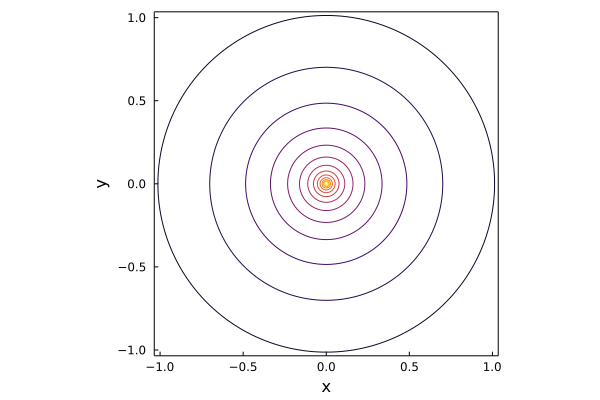

In [4]:
s = computeψ(model);
using Plots
plot(s,g,xlabel="x",ylabel="y")

The function `computeψ` returns a `Nodes` array. If we want to perform differential calculus operations this data, we can use the methods of the  `CartesianGrids` package. For example, we can easily obtain the velocity field from the streamfunction field using the `curl` operation.

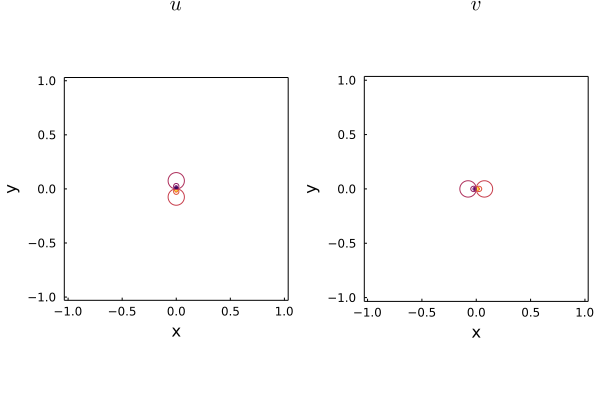

In [5]:
q = curl(s);
plot(q,g,xlabel="x",ylabel="y")

## Accuracy of the discretized Poisson equation
To verify that the discretization technique of the Poisson equation is second-order accurate, we perform a mesh refinement analysis for a flow consisting of point vortices of random strenght that are randomly positioned on the lower-left quadrant of a square domain.

The error is calculated by comparing the numerically calculated streamfunction field with the exact solution for the streamfunction field. We therefore need a function to calculate the exact streamfunction.

In [6]:
function ψVortex!(ψ::Nodes{Dual,nx,ny},vortex::Vortex,g::PhysicalGrid) where {nx,ny}
    x,y = coordinates(ψ,g)
    for i in 2:nx-1, j in 2:ny-1
        r = sqrt((x[i]-vortex.x)^2+(y[j]-vortex.y)^2)
        ψ[i,j] = ψVortex(r,vortex.Γ)
    end
end

function ψVortex(r::Real,Γ::Real)
    return -Γ/(2π)*log(r)
end

ψVortex (generic function with 1 method)

We create four vortices with random strenghts, randomly positioned in the lower-left quadrant of the domain.

In [7]:
nv = 4;
vl = VortexList(Vortex.(-Lx/4 .+ 0.4*Lx*(rand(nv).-0.5),-Lx/4 .+ 0.4*Lx*(rand(nv).-0.5),0.5*rand(nv).+0.5));

Next, we create a series of grids, with each grid doubling the number of grid points of the previous grid in each direction.

In [8]:
grids = [PhysicalGrid(xlim,ylim,Lx/(nx-2)) for nx in [2^p for p in 5:9]];

The error is calculated as $\epsilon = \Vert \psi(\mathsf{x},\mathsf{y})/\Delta x - \mathsf{s} \Vert_2 / \Vert \mathsf{s} \Vert_2$, for which we use the `norm` function.

In [9]:
using LinearAlgebra: norm

We now loop over the grids and calculate the error.

In [10]:
errors = []
gridspacings = []
for g in grids
    # LGF
    model = VortexModel(g,vortices=vl)
    s_lgf = computeψ(model);

    # Exact solution
    s_exact = Nodes(Dual,size(g))
    s_temp = Nodes(Dual,size(g))
    for v in vl
        ψVortex!(s_temp,v,g)
        s_exact += s_temp
    end

    # Bring to same reference level. A constant value can be added/subtracted to any potential flow solution
    s_lgf .-= s_lgf[g.I0[1],2];
    s_exact .-= s_exact[g.I0[1],2];

    error = s_lgf-s_exact
    idx = g.I0[1] + 1 : g.N[1] - 1 # Only look at top right corner
    push!(errors,norm(error[idx,idx])/norm(s_lgf[idx,idx]))
    push!(gridspacings,g.Δx)
end

┌ Warning: Assignment to `model` in soft scope is ambiguous because a global variable by the same name exists: `model` will be treated as a new local. Disambiguate by using `local model` to suppress this warning or `global model` to assign to the existing global variable.
└ @ string:5


And finally, we create a log-log plot of the error versus the grid spacing.

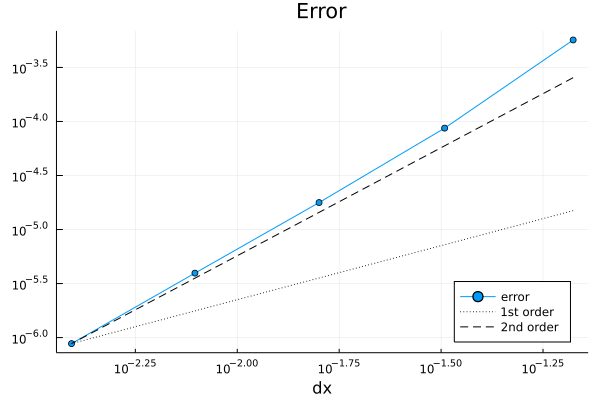

In [11]:
firstorder=(errors[end]/gridspacings[end].*gridspacings).^1
secondorder=(sqrt(errors[end])/gridspacings[end].*gridspacings).^2
p=plot(gridspacings,errors,xaxis=:log,yaxis=:log,marker=:circle,lab="error",xlabel="dx",legend=:bottomright,title="Error")
plot!(gridspacings,firstorder,lab="1st order",linestyle=:dot,linecolor=:black)
plot!(gridspacings,secondorder,lab="2nd order",linestyle=:dash,linecolor=:black)

## Corotating point vortices
Now we will try advancing a vortex model in time. The simplest unsteady vortex model consists of two point vortices. When both point vortices have the same strength, they will rotate around each other on a trajectory that is easy to describe analytically. In this example, we will compare the analytical and simulated trajectories during one revolution.

First create two vortices at a distance $d$ from each other and give them a strength $\Gamma$

In [12]:
d = Lx/2
Γ = 1
v1 = Vortex(d/2,0.0,Γ);
v2 = Vortex(-d/2,0.0,Γ);

We can analytically determine the time $T_v$ it takes for these vortices to complete one revolution around their centroid.

In [13]:
Vθ = Γ/(2*π*d); # Analytical tangential velocity
Tv = π*d/Vθ; # Analytical period

Let's now create a vortex model with the two point vortices.

In [14]:
model = VortexModel(g,vortices=[v1,v2]);

If we update the positions of the point vortices repeatedly to simulate the model advancing in time from $t=0$ to $t=T_v$, we can check if they end up again at their original positions.

In [15]:
Δt = 0.005;
T = 0:Δt:Tv;

To step in time, we update the position of the $q$th vortex as $X^{n+1}_q = X^{n}_q + Δt Ẋ^{n}_q$ (forward Euler) in a for-loop. The flow velocity at the locations of the vortices $Ẋ$ is obtained with `computevortexvelocities`, which regularizes the vorticity to the grid, solves the potential flow system, and interpolates the velocities from the grid to the vortex locations as

$\left(U_{q}, V_{q}\right)=\sum_{i, j} \mathsf{v}_{i j} d\left(\frac{\mathsf{x}_{i}-X_{q}}{\Delta x}\right)\left(\frac{\mathsf{y}_{j}-Y_{q}}{\Delta x}\right),$

where $v$ is the velocity field on the nodes.

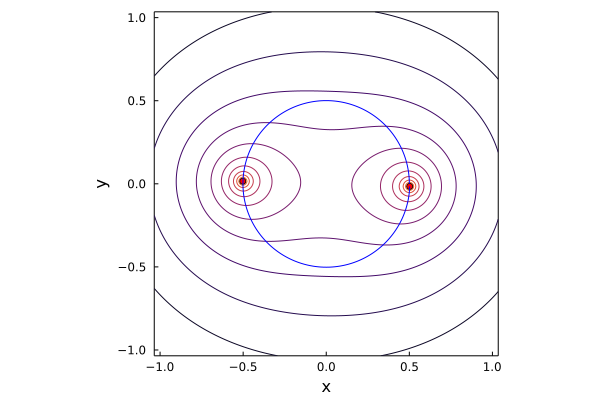

In [16]:
X_hist = []
for t in T
    Ẋ = computevortexvelocities(model)
    X = getvortexpositions(model)
    X = X + Ẋ*Δt
    setvortexpositions!(model,X)
    push!(X_hist,X)
end

ψ = computeψ(model);
plot(ψ,g)
scatter!(model.vortices,color=:red)
plot!((X->X[1]).(X_hist),(X->X[3]).(X_hist),color=:blue,xlabel="x",ylabel="y")

## Corotating vortex patches
A more complex example is the evolution of two circular regions of spatially uniform vorticity that have an equal radius $r_0$ and strength $\Gamma$, and whose centers are separated by a distance $d_0$. Note that if these were two point vortices, their period would be equal to $2 {\pi}^2 {d_0}^2 / \Gamma_0$, so we will take the final time of our simulation equal to this to ensure it includes one period.

In [17]:
Γ0 = 1.0;
d0 = 1.0;
tf = 2*π^2*d0^2/Γ0;
tspan = (0.0,tf);

To simulate their evolution, we discretize these vortex patches with point vortices arranged on concentric rings using the following function.

In [18]:
function vortexpatch!(vort,xc::Float64,yc::Float64,Γ,radius,nring::Int)
    Δr = radius/(nring-1/2)
    dΓ = Γ/(1+8*nring*(nring-1)/2)
    push!(vort,Vortex(xc,yc,dΓ))
    for ir in 1:nring-1
        nθ = 8*ir
        for j = 0:nθ-1
            push!(vort,Vortex(xc + ir*Δr*cos(2π*j/nθ),yc + ir*Δr*sin(2π*j/nθ),dΓ))
        end
    end
    return vort
end

vortexpatch(xc,yc,Γ,radius,nring::Int) = vortexpatch!(Vortex[],xc,yc,Γ,radius,nring)

xlim = (-2,2);
ylim = (-2,2);
Δx = 0.05;
g = PhysicalGrid(xlim,ylim,Δx);

In our last example, we implemented a forward Euler time stepping routine. In this example, we will make use of the fourth-order Runge-Kutta time stepping algorithm of `OrdinaryDiffEq.jl` to get more accurate results.

In [19]:
using OrdinaryDiffEq

To construct the `ODEProblem` from this package, we will have to provide a right-hand side function.

In [20]:
function rhs(X,model,t)
    setvortexpositions!(model,X)
    Ẋ = computevortexvelocities(model)
    return Ẋ
end

rhs (generic function with 1 method)

We will simulate two cases with different values for $r_0/d_0$, the ratio of the vortex patch radius to the distance between them.

┌ Info: Saved animation to 
└   fn = "/var/folders/24/5y37zfb13sb5y3ph0bq_z1tm0000gn/T/jl_W7ZMNV.gif"


Plots.AnimatedGif("/var/folders/24/5y37zfb13sb5y3ph0bq_z1tm0000gn/T/jl_W7ZMNV.gif")
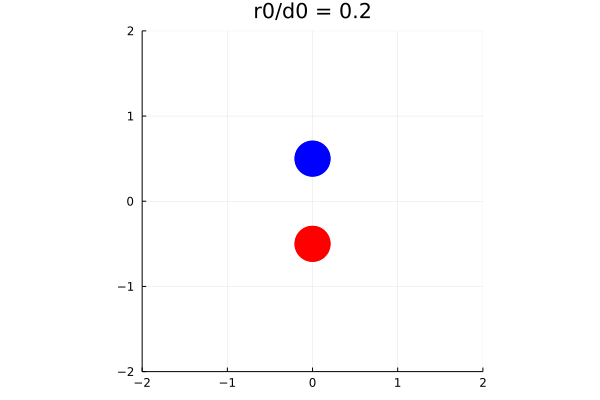

In [21]:
r0 = 0.2*d0;
vortices = vcat(vortexpatch(0.0,0.0+d0/2,Γ0,r0,10),vortexpatch(0.0,0.0-d0/2,Γ0,r0,10));
vortexcolors = vcat(fill(:blue,length(vortices)÷2),fill(:red,length(vortices)÷2));
model = VortexModel(g,vortices=vortices);
X = getvortexpositions(model)
prob = ODEProblem(rhs,X,tspan,model);
sol = solve(prob,dt=0.1,RK4(),dense=false,adaptive=false);
animation = @gif for i=1:length(sol.t)-1
    plot(xlims=xlim,ylims=ylim,ratio=:equal,legend=:none,title="r0/d0 = $(r0/d0)")
    scatter!(sol.u[i].u,sol.u[i].v,markerstrokewidth=0,markersize=3,color=vortexcolors)
end

If the ratio $r_0/d_0$ is big enough, the two vortex patches merge with eachother, a result that has been widely reported in literature [^1].

┌ Info: Saved animation to 
└   fn = "/var/folders/24/5y37zfb13sb5y3ph0bq_z1tm0000gn/T/jl_F5JJtF.gif"


Plots.AnimatedGif("/var/folders/24/5y37zfb13sb5y3ph0bq_z1tm0000gn/T/jl_F5JJtF.gif")
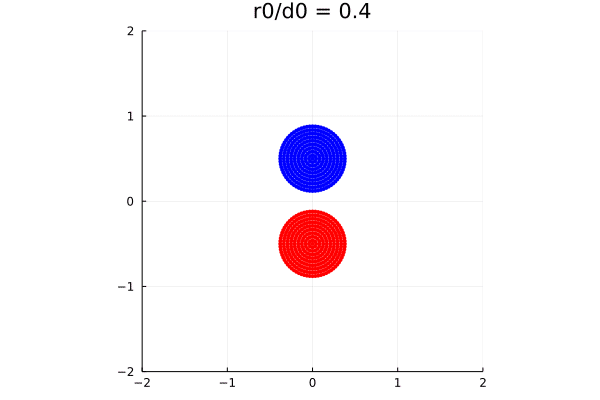

In [22]:
r0 = 0.4*d0;
vortices = vcat(vortexpatch(0.0,0.0+d0/2,Γ0,r0,10),vortexpatch(0.0,0.0-d0/2,Γ0,r0,10));
vortexcolors = vcat(fill(:blue,length(vortices)÷2),fill(:red,length(vortices)÷2));
model = VortexModel(g,vortices=vortices);
X = getvortexpositions(model)
prob = ODEProblem(rhs,X,tspan,model);
sol = solve(prob,dt=0.1,RK4(),dense=false,adaptive=false);
animation = @gif for i=1:length(sol.t)-1
    plot(xlims=xlim,ylims=ylim,ratio=:equal,legend=:none,title="r0/d0 = $(r0/d0)")
    scatter!(sol.u[i].u,sol.u[i].v,markerstrokewidth=0,markersize=3,color=vortexcolors)
end

[^1]: Eldredge J. D. (2019) "Mathematical  Modeling  of  Unsteady  Inviscid  Flows, Interdisciplinary Applied Mathematics" *Springer*, vol. 50.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*